# Performance Analysis of Model

This notebook will guide through my performance analysis of the model.

We'll target a few questions:
- How well does the model perform?
- What assumptions are made?
- What does the model perform better on? What about the poor ones?

## Preparation

As usual, we'll load relevant libraries and ...
- Load our test data
- Load our model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl

from opal.score.collaborative_filtering.neu_mf import NeuMF
from opal.score.datamodule import ScoreDataModule

dm = ScoreDataModule(
    ds_yyyy_mm="2023_04", batch_size=16,
    ds_set="10000",
    accuracy_bounds=(0.85, 1),
)

Download Files: 
	- D:/Repositories/PycharmProjects/opal/data/2023_04_01_performance_mania_top_10000.tar.bz2
Derived Files: 
	- D:/Repositories/PycharmProjects/opal/data/2023_04_01_performance_mania_top_10000/___.sql (All SQL Files are extracted)
Proceeding to Download ...
File exists. Skipping Download


D:\Repositories\PycharmProjects\opal\opal\score\datamodule\score_datamodule.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['enabled_mods'] = df['enabled_mods'].astype(int)
D:\Repositories\PycharmProjects\opal\opal\score\datamodule\score_datamodule.py:74: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_map = pd.read_csv(csv_map)


In [2]:
net = NeuMF.load_from_checkpoint("checkpoints/epoch=8-step=55773.ckpt")

In [3]:
net

NeuMF(
  (model): NeuMFModule(
    (u_mf_emb): Embedding(30625, 8)
    (m_mf_emb): Embedding(10371, 8)
    (mf_net): Sequential(
      (0): NeuMFBlock(
        (net): Sequential(
          (0): Linear(in_features=8, out_features=8, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): NeuMFBlock(
        (net): Sequential(
          (0): Linear(in_features=8, out_features=8, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (u_mlp_emb): Embedding(30625, 8)
    (m_mlp_emb): Embedding(10371, 8)
    (mlp_net): Sequential(
      (0): NeuMFBlock(
        (net): Sequential(
          (0): Linear(in_features=16, out_features=128, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): NeuMFBlock(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=64, bias=True)
          (1): ReLU()
          (2): Dropout(p=

In [4]:
# Set to evaluate mode (no gradient update)
net.eval()
trainer = pl.Trainer(accelerator='cpu', limit_predict_batches=512)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


## Predicting
We'll use our validation data to predict.

In [5]:
%%capture
y = trainer.predict(net, datamodule=dm)
y_preds = []
y_trues = []
for x_uid_real, x_mid_real, y_pred, y_true in y:
    y_preds.append(y_pred)
    y_trues.append(y_true)
y_preds = np.stack(y_preds).flatten()
y_trues = np.stack(y_trues).flatten()

Missing logger folder: D:\Repositories\PycharmProjects\opal\models\V2_2023_04\lightning_logs


# Analysis

We'll firstly do some quick viz to get an intuition of the data

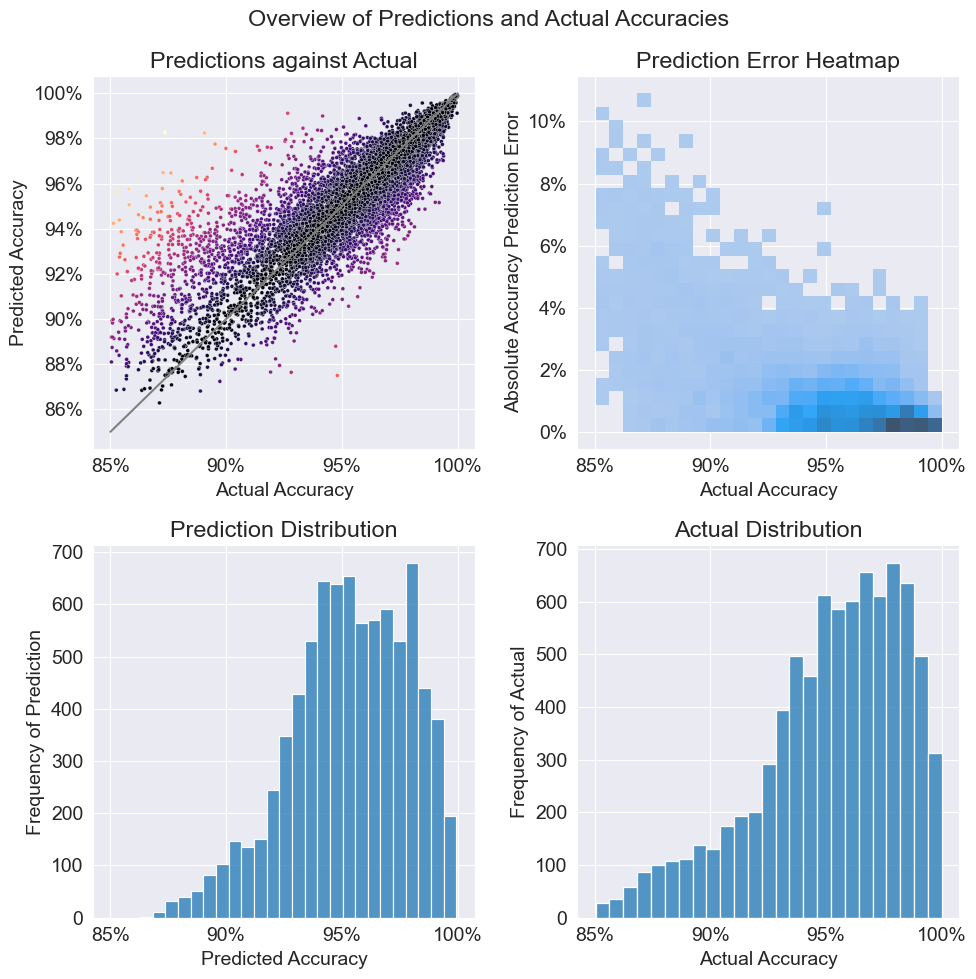

In [6]:
import seaborn as sns
import matplotlib.ticker as mtick

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 10))
plt.suptitle("Overview of Predictions and Actual Accuracies")

ax1 = plt.subplot(221)
sns.lineplot(x=[0.85, 1], y=[0.85, 1], color='gray')
sns.scatterplot(x=y_trues, y=y_preds, s=8, c=np.abs(y_trues - y_preds),
                cmap='magma')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Predictions against Actual")
plt.xlabel("Actual Accuracy")
plt.ylabel("Predicted Accuracy")

ax2 = plt.subplot(222)
ax2.sharex(ax1)
sns.histplot(x=y_trues, y=np.abs(y_preds - y_trues), bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Prediction Error Heatmap")
plt.xlabel("Actual Accuracy")
plt.ylabel("Absolute Accuracy Prediction Error")

ax3 = plt.subplot(223)
ax3.sharex(ax1)
sns.histplot(x=y_preds, bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Prediction Distribution")
plt.xlabel("Predicted Accuracy")
plt.ylabel("Frequency of Prediction")

ax4 = plt.subplot(224)
ax4.sharex(ax1)
sns.histplot(x=y_trues, bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Actual Distribution")
plt.xlabel("Actual Accuracy")
plt.ylabel("Frequency of Actual")
plt.tight_layout()
plt.savefig("overview.png")
plt.show()

**Biases Correction**

If you've seen my previous analysis, you'll see that our predictions for lower (actual) accuracies are biased.
This is because our model assumes a normal distribution for our input data, however, it's actually heavily skewed.
Despite the sigmoid correction, it was still insufficient to correct the biases, thus, alternatively, we used a `QuantileTransformer` to force transform data into a normal distribution.

**Score Limiting**

We limited the input to only have scores > 750,000. Thus, accuracies taper around 90.00%.
This may have caused the model to not be able to predict scores beyond 90.00%, however we're not that interested in those predictions.

Despite that, it may prove to be more useful if we included those, so we'll circle back next time.


## Analysis of input

We also have our `DataFrame` of input data, let's take a glance

In [7]:
df = dm.df

In [8]:
df.head()

,difficultyrating,diff_overall,diff_size,beatmap_id,filename,user_id,year,score,accuracy,speed,uid,mid,uid_le,mid_le
0,3.39962,8.0,7.0,192345.0,FamiRockP - Oni Kanojo (Entozer) [Hard].osu,75777.0,2016,928747.0,0.185671,0.0,75777/2016,192345/0,26261,2500
1,3.39962,8.0,7.0,192345.0,FamiRockP - Oni Kanojo (Entozer) [Hard].osu,242795.0,2015,916065.0,0.134122,0.0,242795/2015,192345/0,17296,2500
2,3.39962,8.0,7.0,192345.0,FamiRockP - Oni Kanojo (Entozer) [Hard].osu,437945.0,2014,795309.0,-0.919703,0.0,437945/2014,192345/0,22174,2500
3,3.39962,8.0,7.0,192345.0,FamiRockP - Oni Kanojo (Entozer) [Hard].osu,443656.0,2014,715434.0,-1.370304,0.0,443656/2014,192345/0,22242,2500
4,3.39962,8.0,7.0,192345.0,FamiRockP - Oni Kanojo (Entozer) [Hard].osu,563262.0,2015,814100.0,-0.920106,0.0,563262/2015,192345/0,23758,2500


We see 6 columns, the first 2 are `str` columns, for `LabelEncoder` to encode, the result is the last 2.

E.g.

`uid=U/YYYY` means the user, with user id `U`, with the score in year `YYYY`.

`mid=M/S` means the map, with beatmap id `M` with speed of map `S`.
- `S=1`: Double Time
- `S=0`: Normal Time
- `S=-1`: Half Time

Note that our accuracies are quantile transformed.

# Performance of Model

Now, let's figure out how well the model performed on the prediction.

In [9]:
from sklearn.metrics import r2_score
print("R2:", r2_score(y_true, y_pred))
print("MAE:", np.abs(y_preds - y_trues).mean())
print("RMSE:", ((y_preds - y_trues) ** 2).mean() ** 0.5)

R2: 0.7188607403259554
MAE: 0.011421256
RMSE: 0.016825681342725322


Sort of tells us that the general error is around 1%, which is acceptable.

Let's find out the errors of each percentage

C:\Users\johnc\AppData\Local\Temp\ipykernel_27612\3748057135.py:5: RuntimeWarning: Mean of empty slice.
  return np.abs(y_preds - y_trues).mean(), ((y_preds - y_trues) ** 2).mean() ** 0.5
D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


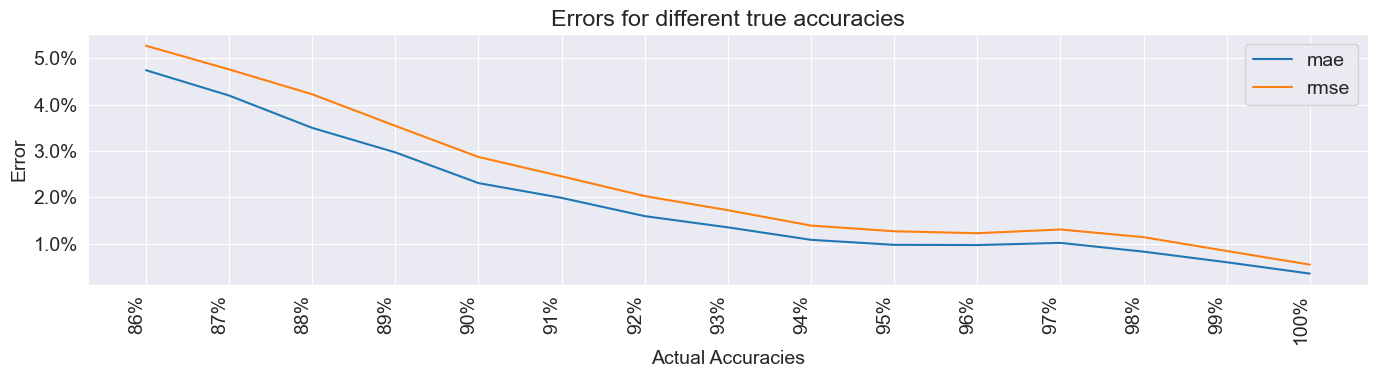

In [10]:
def get_error(y_preds, y_trues, a, b):
    y_preds = y_preds[(y_trues >= a) & (y_trues < b)]
    y_trues = y_trues[(y_trues >= a) & (y_trues < b)]

    return np.abs(y_preds - y_trues).mean(), ((y_preds - y_trues) ** 2).mean() ** 0.5


errors = []
bounds = np.linspace(0.7, 1, 31)
for a, b in zip(bounds[:-1], bounds[1:]):
    mae, rmse = get_error(y_preds, y_trues, a, b)
    errors.append([f"{b:.0%}", mae, rmse])

df_errors = pd.DataFrame(errors, columns=['bounds', 'mae', 'rmse'])
plt.figure(figsize=(14, 4))
sns.lineplot(data=df_errors, x='bounds', y='mae', label='mae')
sns.lineplot(data=df_errors, x='bounds', y='rmse', label='rmse')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.title("Errors for different true accuracies")
plt.xlabel("Actual Accuracies")
plt.ylabel("Error")
_ = plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.savefig("error.png")

With domain expert input, it's logical.
There is significantly large deviations for lower accuracies, which is largely due to the undersampling of scores within that range. Refer to the diagram above to see the distribution of scores.

Fortunately, this isn't detrimental to common business use cases, as the scores of interest are those of higher accuracies.